In [1]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.rendering import render_depth_map
from text3d2video.utilities.video_util import pil_frames_to_clip
torch.set_grad_enabled(False)

In [2]:
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingPipeline
)
from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.texgen_pipeline import TexGenPipeline

device = torch.device("cuda")
dtype = torch.float16
sd_repo = "runwayml/stable-diffusion-v1-5"
controlnet_repo = "lllyasviel/control_v11f1p_sd15_depth"
pipe = load_pipeline(GenerativeRenderingPipeline, sd_repo, controlnet_repo)

texturing_pipe = TexGenPipeline(pipe.vae, pipe.text_encoder, pipe.tokenizer, pipe.unet, pipe.scheduler, pipe.controlnet)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [8]:
# MultiView
import numpy as np
import torch
from pytorch3d.io import load_obj, load_objs_as_meshes

from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from text3d2video.utilities.ipython_utils import display_ims
from text3d2video.utilities.mesh_processing import normalize_meshes
from pytorch3d.renderer import FoVPerspectiveCameras

mesh_path = "data/meshes/cat_statue.obj"
device = "cuda"

# read mesh
verts, faces, aux = load_obj(mesh_path)
verts_uvs = aux.verts_uvs.to(device)
faces_uvs = faces.textures_idx.to(device)

mesh = load_objs_as_meshes([mesh_path], device=device)
mesh = normalize_meshes(mesh)

dist = 6.5

# Small Rotation
# n_frames = 10
# center_angle = 0
# shift = 20
# angles = np.linspace(center_angle-shift, center_angle+shift, n_frames)

# Full Rotation
angles = np.linspace(0, 360, 10)

R, T = turntable_extrinsics(dists=dist, angles=angles)

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

prompt_suffixes = []
for angle in angles:
    view = cam_view_prompt(angle, 0)
    prompt_suffixes.append(f", {view} view")

In [4]:
# Handstand
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("handstand:latest")

# full
# frame_indices = anim.frame_indices(20)

# begining part
# up_to = 15
# frame_indices = torch.linspace(0, up_to, 7, dtype=torch.long)

# handstand
frame_indices = torch.linspace(30, 37, 7, dtype=torch.long)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()

prompt_suffixes = None

In [5]:
# Rumba 
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("ymca:latest")

# frame_indices = torch.linspace(30, 50, 7, dtype=torch.long)
frame_indices = anim.frame_indices(20)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()
# prompt_suffixes = None

In [6]:
# MMA
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag("mma:latest")

frame_indices = torch.linspace(0, 50, 30, dtype=torch.long)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()
# prompt_suffixes = None

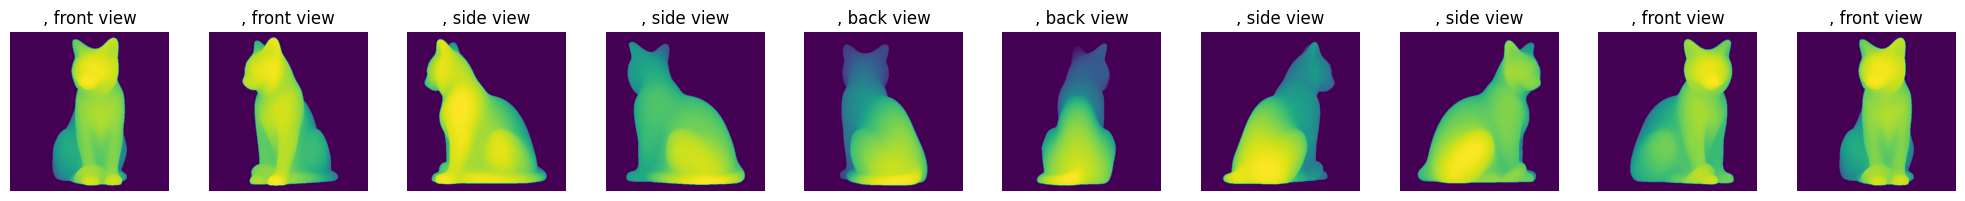

In [9]:
prompt = "Deadpool"
seed = 0
depths = render_depth_map(frame_meshes, frame_cams)
display_ims(depths, titles=prompt_suffixes)

In [10]:
from text3d2video.utilities.ipython_utils import display_vid


display_vid(pil_frames_to_clip(depths))

In [194]:
# Call GR
from pathlib import Path
from text3d2video.noise_initialization import (
    FixedNoiseInitializer,
    RandomNoiseInitializer,
    UVNoiseInitializer,
)
from text3d2video.pipelines.generative_rendering_pipeline import (
    GenerativeRenderingConfig,
)
from text3d2video.utilities.logging import GrLogger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

gr_config = GenerativeRenderingConfig(
    do_pre_attn_injection=True,
    do_post_attn_injection=True,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.0,
    chunk_size=5,
    num_keyframes=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(seed)

kf_generator = torch.Generator(device="cuda")
kf_generator.manual_seed(0)

logger = GrLogger(Path("data.h5"), n_save_times=10, n_save_frames=10)
logger.delete_data()
logger.open_write()
logger.enabled = False

noise_initializer = FixedNoiseInitializer()
noise_initializer = RandomNoiseInitializer()
noise_initializer = UVNoiseInitializer(noise_texture_res=200)

video_frames = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=gr_config,
    noise_initializer=noise_initializer,
    generator=generator,
    kf_generator=kf_generator,
    logger=logger,
    prompt_suffixes=prompt_suffixes,
)

100%|██████████| 15/15 [00:44<00:00,  2.96s/it]


In [198]:
# Call ControlNet
controlnet_config = GenerativeRenderingConfig(
    do_pre_attn_injection=False,
    do_post_attn_injection=False,
    feature_blend_alpha=1.0,
    attend_to_self_kv=False,
    mean_features_weight=0.0,
    chunk_size=5,
    num_keyframes=5,
    num_inference_steps=15,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(seed)

noise_initializer = UVNoiseInitializer(noise_texture_res=200)

frames_controlnet = pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    generative_rendering_config=controlnet_config,
    noise_initializer=noise_initializer,
    generator=generator,
    kf_generator=kf_generator,
    logger=None,
    prompt_suffixes=prompt_suffixes,
)

100%|██████████| 15/15 [00:19<00:00,  1.28s/it]


In [ ]:
from pathlib import Path
from text3d2video.pipelines.texgen_pipeline import TexGenConfig
from text3d2video.utilities.logging import H5Logger

module_paths = [
    # "down_blocks.0.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.0.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.1.attentions.1.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.0.transformer_blocks.0.attn1",
    # "down_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "mid_block.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.1.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.2.attentions.2.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.0.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.1.transformer_blocks.0.attn1",
    "up_blocks.3.attentions.2.transformer_blocks.0.attn1",
]

texgen_config = TexGenConfig(
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    module_paths=module_paths,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

images = texturing_pipe(
    prompt,
    frame_meshes,
    frame_cams,
    verts_uvs,
    faces_uvs,
    texgen_config=texgen_config,
    generator=generator,
    prompt_suffixes=prompt_suffixes,
    logger=logger,
)

logger.close()

 30%|███       | 3/10 [00:10<00:25,  3.62s/it]

In [25]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import video_grid

# video_controlnet = pil_frames_to_clip(frames_controlnet)
# video_gr = pil_frames_to_clip(video_frames)

comparison_vids = [
    (pil_frames_to_clip(depths), "depth"),
    (pil_frames_to_clip(images), "TexGen"),
    # pil_frames_to_clip(video_frames),
    # pil_frames_to_clip(images),
]

labels = [label for _, label in comparison_vids]
clips = [clip for clip, _ in comparison_vids]


comparison_vid = video_grid(
    [clips],
    x_labels=labels,
)
display_vid(comparison_vid, width=1000)

In [143]:
from einops import rearrange
import torchvision.transforms.functional as TF
from text3d2video.backprojection import (
    project_visible_texels_to_camera,
    update_uv_texture,
)

n_frames = len(video_frames)


# compute projections
uv_res = 100
image_res = 300
projections = [
    project_visible_texels_to_camera(m, c, verts_uvs, faces_uvs, uv_res)
    for m, c in zip(frame_meshes, frame_cams)
]

empty_textures = [torch.zeros_like(verts_uvs) for _ in frame_meshes]

# project white image to each frame
white_im = torch.ones(1, image_res, image_res).cuda()
textures = []
for i in range(n_frames):
    empty_texture = torch.zeros(uv_res, uv_res, 1, device=device)
    projection = projections[i]
    texture = update_uv_texture(empty_texture, white_im, projection.xys, projection.uvs)
    textures.append(texture)

textures = torch.stack(textures)
textures_pil = [TF.to_pil_image(rearrange(t, "h w c -> c h w")) for t in textures]
texture_sum = textures.mean(dim=0)[:, :, 0].cpu()

In [127]:
from matplotlib.cm import get_cmap
from torch import Tensor

cmap = get_cmap("turbo")

texture_cmap = cmap(texture_sum)[:, :, 0:3]
texture_cmap = Tensor(texture_cmap).cuda()

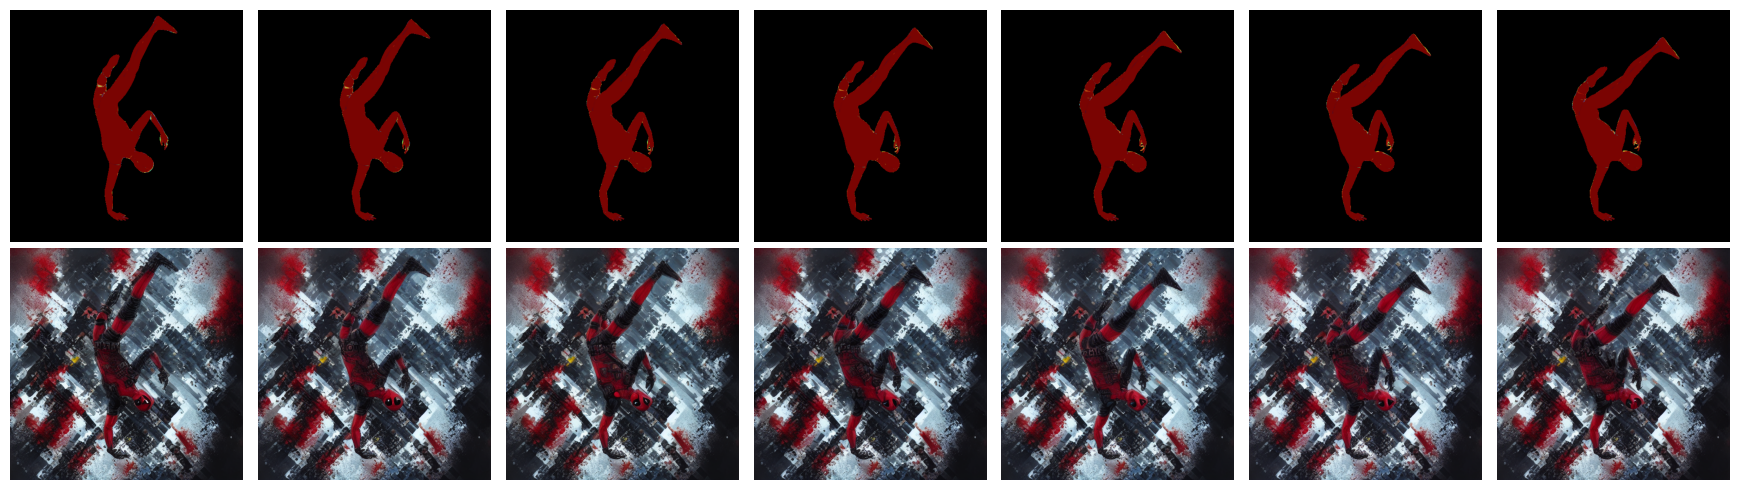

In [128]:
from text3d2video.rendering import render_texture
from text3d2video.utilities.ipython_utils import display_ims_grid

renders = render_texture(
    frame_meshes, frame_cams, texture_cmap, verts_uvs, faces_uvs
)

renders_pil = [TF.to_pil_image(r) for r in renders]
display_ims_grid([renders_pil, video_frames])